<a href="https://colab.research.google.com/github/PearlSikka/SentimentAnalysis_Twitter/blob/main/SentimentAnalysis_Twitter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Classification

Classifying the overall sentiment of a tweet as positive, negative or neutral.



**IMPORT necessary packages**


In [ ]:
# Import necessary packages
import re
import string
from os.path import join
import numpy as np                                                                #for array manipulations
import pandas as pd                                                               #for dataframe manipulations
import seaborn as sns                                                             #for plots
import nltk                                                                       #to process and manipulate text data
from nltk import PorterStemmer
import csv
import time
import random
import os
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 
nltk.download('stopwords')
nltk.download('wordnet')
stop=set(stopwords.words('english'))
stemmer=PorterStemmer()


from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer       #for feature extraction
from sklearn import svm                                                           #SVM
from sklearn.naive_bayes import MultinomialNB                                     #Naive Bayes
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier                               #RandomForest
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score,f1_score   
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from keras.preprocessing.text import Tokenizer                                    #Keras Tokenizer
from keras.preprocessing.sequence import pad_sequences                            

import torch                                                                      #pytorch 
from torch import nn                                                              #pytorch neural network building class
from torch.utils import data
from torch.nn import functional as F
import torch.optim as optim



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


**LOAD DATASET: Loading training, validation/dev and test datasets.**

In [ ]:
# Define test sets
testsets = ['twitter-test1.txt', 'twitter-test2.txt', 'twitter-test3.txt']      #testsets. *Please add the additional testsets here*

In [ ]:
datadir= '/content/semeval-tweets/'                                             #load data directory. *Please change according to the location of data*

df_test={}                                                        

data_df_train=pd.read_csv(datadir +'twitter-training-data.txt', sep='\t', header=None, quoting=csv.QUOTE_NONE, error_bad_lines=False)   #reading training dataset
data_df_dev=pd.read_csv(datadir +'twitter-dev-data.txt', sep='\t', header=None, quoting=csv.QUOTE_NONE, error_bad_lines=False)          #reading dev dataset

data_df_train.rename(columns={0:'id',1:'sentiment',2:'tweet'},inplace=True)                                  #to give columns meaningful name
data_df_dev.rename(columns={0:'id',1:'sentiment',2:'tweet'},inplace=True)                             

data_df_train=data_df_train.set_index('id')                                                                    
data_df_dev=data_df_dev.set_index('id')

k=0
for test in testsets:                                                                                        #reading testsets
  k=k+1
  df_test['data_df_test'+str(k)]= pd.read_csv(datadir + test, sep='\t', header=None, quoting=csv.QUOTE_NONE, error_bad_lines=False)
  df_test['data_df_test'+str(k)].rename(columns={0:'id',1:'sentiment',2:'tweet'},inplace=True)
  df_test['data_df_test'+str(k)]=df_test['data_df_test'+str(k)].set_index('id')

data_df_train.head()


,sentiment,tweet
id,,
335104872099066692,positive,Felt privileged to play Foo Fighters songs on ...
796528524030124618,positive,"""@AaqibAfzaal Pakistan may be an Islamic count..."
760964834217238632,positive,Happy Birthday to the coolest golfer in Bali! ...
147713180324524046,negative,@SimpplyA TMILLS is going to Tucson! But the 2...
732302280474120023,negative,Hmmmmm where are the #BlackLivesMatter when ma...


In [ ]:
print(f'There are {data_df_train.shape[0]} tweets in training set')
print(f'There are {data_df_dev.shape[0]} tweets in dev set')

for i in df_test:
  print(f'There are {df_test[i].shape[0]} tweets in testset {i}')

There are 45101 tweets in training set
There are 2000 tweets in dev set
There are 3531 tweets in testset data_df_test1
There are 1853 tweets in testset data_df_test2
There are 2379 tweets in testset data_df_test3


In [ ]:
print(f"Missing sample in training set: {data_df_train.isnull().values.any()}")
print(f"Missing sample in development set: {data_df_dev.isnull().values.any()}")

for i in df_test:
  print(f"Missing sample in test set: {df_test[i].isnull().values.any()}")

Missing sample in training set: False
Missing sample in development set: False
Missing sample in test set: False
Missing sample in test set: False
Missing sample in test set: False


**CLASS DISTRIBUTION**: Before starting with analysis, it's important to see the distribution of values in classes in training set.

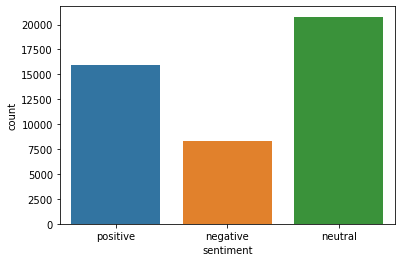

In [ ]:
sns.countplot(x='sentiment', data=data_df_train)

**PREPROCESS TWEETS**

In [ ]:
def preprocess_text(text):

    text = re.sub(r"he's", "he is", text)                                        #removing contractions
    text = re.sub(r"there's", "there is", text)
    text = re.sub(r"We're", "We are", text)
    text = re.sub(r"That's", "That is", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"they're", "they are", text)
    text = re.sub(r"wouldn't", "would not", text)
    text = re.sub(r"Can't", "Cannot", text)
    text = re.sub(r"wasn't", "was not", text)
    text = re.sub(r"don\x89Ûªt", "do not", text)
    text = re.sub(r"aren't", "are not", text)
    text = re.sub(r"isn't", "is not", text)
    text = re.sub(r"What's", "What is", text)
    text = re.sub(r"haven't", "have not", text)
    text = re.sub(r"hasn't", "has not", text)
    text = re.sub(r"There's", "There is", text)
    text = re.sub(r"He's", "He is", text)
    text = re.sub(r"It's", "It is", text)
    text = re.sub(r"You're", "You are", text)
    text = re.sub(r"I'M", "I am", text)
    text = re.sub(r"shouldn't", "should not", text)
    text = re.sub(r"wouldn't", "would not", text)
    text = re.sub(r"i'm", "I am", text)
    text = re.sub(r"I\x89Ûªm", "I am", text)
    text = re.sub(r"I'm", "I am", text)
    text = re.sub(r"Isn't", "is not", text)
    text = re.sub(r"Here's", "Here is", text)
    text = re.sub(r"you've", "you have", text)
    text = re.sub(r"you\x89Ûªve", "you have", text)
    text = re.sub(r"we're", "we are", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"we've", "we have", text)
    text = re.sub(r"it\x89Ûªs", "it is", text)
    text = re.sub(r"doesn\x89Ûªt", "does not", text)
    text = re.sub(r"It\x89Ûªs", "It is", text)
    text = re.sub(r"Here\x89Ûªs", "Here is", text)
    text = re.sub(r"who's", "who is", text)
    text = re.sub(r"I\x89Ûªve", "I have", text)
    text = re.sub(r"y'all", "you all", text)
    text = re.sub(r"can\x89Ûªt", "cannot", text)
    text = re.sub(r"would've", "would have", text)
    text = re.sub(r"it'll", "it will", text)
    text = re.sub(r"we'll", "we will", text)
    text = re.sub(r"wouldn\x89Ûªt", "would not", text)
    text = re.sub(r"We've", "We have", text)
    text = re.sub(r"he'll", "he will", text)
    text = re.sub(r"Y'all", "You all", text)
    text = re.sub(r"Weren't", "Were not", text)
    text = re.sub(r"Didn't", "Did not", text)
    text = re.sub(r"they'll", "they will", text)
    text = re.sub(r"they'd", "they would", text)
    text = re.sub(r"DON'T", "DO NOT", text)
    text = re.sub(r"That\x89Ûªs", "That is", text)
    text = re.sub(r"they've", "they have", text)
    text = re.sub(r"i'll", "I will", text)
    text = re.sub(r"weren't", "were not", text)
    text = re.sub(r"They're", "They are", text)
    text = re.sub(r"let's", "let us", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"you're", "you are", text)
    text = re.sub(r"i've", "I have", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"i'll", "I will", text)
    text = re.sub(r"doesn't", "does not", text)
    text = re.sub(r"i'd", "I would", text)
    text = re.sub(r"didn't", "did not", text)
    text = re.sub(r"ain't", "am not", text)
    text = re.sub(r"you'll", "you will", text)
    text = re.sub(r"I've", "I have", text)
    text = re.sub(r"Don't", "do not", text)
    text = re.sub(r"I'll", "I will", text)
    text = re.sub(r"I'd", "I would", text)
    text = re.sub(r"Let's", "Let us", text)
    text = re.sub(r"you'd", "You would", text)
    text = re.sub(r"It's", "It is", text)
    text = re.sub(r"Ain't", "am not", text)
    text = re.sub(r"Haven't", "Have not", text)
    text = re.sub(r"Could've", "Could have", text)
    text = re.sub(r"youve", "you have", text)  
    text = re.sub(r"I'm", "I am", text) 
    text = re.sub(r"youll", "you will", text)
    text = re.sub(r"wont", "will not", text)
    text = re.sub(r"cant", "can not", text)
    text = re.sub(r"dont", "do not", text)

    text=  re.sub(r'^RT[\s]+', '', text)                                        #substituting for retweet RT 
    text = str(text).lower()                                                    #lowercase characters 
    text = re.sub('https?://\S+|www\.\S+', '', text)                            #substituting URLs 
    text = re.sub('\[.*?\]', '', text)                                          #substituting for []
    text = re.sub('\n', '', text)                                               #substituting new line  
    text = re.sub('\w*\d\w*', '', text)                                         #substituting digits  
    text = re.sub('<.:*?>+', '', text)                                          #substituting for <>
    text=  re.sub(r'#', '', text)                                               #substituting for hashtag. Not removing the entire hashtag word
    text=  re.sub('@\w*','',text)                                               #substituting for @
    text = re.sub(r'\s+', ' ', text)                                            #substituting multiple spaces with one space
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)            #removing punctuations
                  
    return text


In [ ]:
def deEmojify(text):                                                                  
  re_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
  
  return re_pattern.sub(r'',text)

In [ ]:
def stem_words(text):                      
    split_word=text.split()                           
    cleaned_word=" ".join([stemmer.stem(i) for i in split_word])                   #to stem the words
    cleaned_word= re.sub(r'\b\w{1}\b','',cleaned_word)                              #to remove words of length 1 
    return cleaned_word

In [ ]:
embed_size = 100                                                                  # how big is each word vector
max_features = 5000                                                               # how many unique words to use (i.e num rows in embedding vector)
max_len = 100                                                                     # max number of words in a question to use
batch_size = 1024                                                                 # how many samples to process at once

**FEATURE SELECTION AND ENGINEERING**

In [ ]:
#feature extraction using TF-IDF 
def tf_feature_eng():
  tf=TfidfVectorizer(min_df=1, max_df=0.9, ngram_range=(1,3), analyzer='word', max_features=5000)       #creating unigram and bigrams      
  tf.fit(data_df_train['tweet'])                                                 #fitting on training set
  return tf


In [ ]:
#feature extraction using Bag-of-words
def bow_feature_eng():
  bow=CountVectorizer(min_df=1, max_df=0.9, ngram_range=(1,3), analyzer='word', max_features=5000)  #creating unigram and bigrams      
  bow.fit(data_df_train['tweet'])                                               #fitting on training set
  return bow

In [ ]:
#feature extraction using glove embedding 
def embedding_matrix_creation(word_index):
 
  num_words_feature=len(word_index)+1                                            #word_index vocabulary length

  embedding_dict={}
  with open('/content/semeval-tweets/glove.6B.100d.txt','r') as f:               #loading glove embedding. *Please change according to data directory*  
      for line in f:
          values=line.split()                                                    
          word=values[0]                                                  
          vectors=np.asarray(values[1:],'float32')
          embedding_dict[word]=vectors                                           #dict of words and word vectors
  f.close()
  
  nb_words = min(max_features+1, len(word_index)+1)                                 
  embedding_matrix=np.zeros((nb_words,embed_size))                               #building embedding matrix (max_features,embed_size)

  for word,i in (word_index.items()):                                            
      if i > max_features:
          continue

      emb_vec=embedding_dict.get(word)
      if emb_vec is not None:
          embedding_matrix[i]=emb_vec                                            #creating embedding matrix with word and word vectors 
    
  return embedding_matrix
  

**TRAINING CLASSIFIER**

In [ ]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid, validation_label):
    
    classifier.fit(feature_vector_train, label)                         # fit the training dataset on the classifier
    predictions = classifier.predict(feature_vector_valid)              # predict the labels on validation dataset
    
    print(f"Accuracy of {classifier} on development set: {accuracy_score(predictions, validation_label)}")
    return classifier

In [ ]:
class LSTM_NN(nn.Module):
    
        def __init__(self):                                               
          super(LSTM_NN, self).__init__()                                           #implementing NN using nn.Module  
          n_classes = 3                                                             #no. of classes
          self.hidden_size = 64                                                     #neurons in hidden layer                                                                          
          drp = 0.5                                                                 
                                                                       
          self.embedding = nn.Embedding(max_features+1, embed_size)                                       #embedding layer with (features,embed_size)
          self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))       #initializing weights
          self.embedding.weight.requires_grad = False                                                     #freeze gradients                     
          self.lstm = nn.LSTM(embed_size, self.hidden_size, bidirectional=True, batch_first=True)         #LSTM layer set with bidirectional=True
          self.linear = nn.Linear(self.hidden_size*4 , 64)                                       #linear layer               
          self.relu = nn.ReLU()                                                                           #nonlinear layer with activation=ReLU
          self.dropout = nn.Dropout(drp)                                                                  #dropout layer
          self.out = nn.Linear(64, n_classes)                                                    #linear output layer 
        
        def forward(self, x):
          
          embedding_mat = self.embedding(x)                                           
          lstm_layer, y = self.lstm(embedding_mat)                                        
          avg_pooled = torch.mean(lstm_layer, 1)                                           #average pooling of output from LSTM layer
          max_pooled, y = torch.max(lstm_layer, 1)                                         #maximum pooling
          pooled_layer = torch.cat((avg_pooled, max_pooled), 1)                                 
          pooled_layer = self.relu(self.linear(pooled_layer))                              #running linear computations of max pooling and avg pooling and then ReLU activation
          pooled_layer = self.dropout(pooled_layer)                                        #dropout layer
          out = self.out(pooled_layer)                                                     #output layer     
          return out


**PREDICTIONS AND EVALUATION**

In [ ]:
def predict(classifier,feature_vector_test, test_label):

  predictions=classifier.predict(feature_vector_test)                                #predictions on testset
  dict_pred=create_dict_from_predictions(predictions,test_label)                     #returning dict of predictions    
  return(dict_pred)


In [ ]:
def create_dict_from_predictions(predictions,test_label):  
  pred=pd.DataFrame({'Id':(test_label.index),'Sentiment':predictions})                 
  pred['Sentiment']=pred['Sentiment'].map({0:'negative',1:'neutral',2:'positive'})   #mapping predictions back to original class labels
  pred=pred.applymap(str)
  return(dict(pred.values))

In [ ]:
#Evaluation code for the test sets
def read_test(testset):
    '''
    readin the testset and return a dictionary
    :param testset: str, the file name of the testset to compare
    '''
    id_gts = {}
    with open(testset, 'r', encoding='utf8') as fh:
        for line in fh:
            fields = line.split('\t')
            tweetid = fields[0]
            gt = fields[1]

            id_gts[tweetid] = gt

    return id_gts


def confusion(id_preds, testset, classifier):
    '''
    print the confusion matrix of {'positive', 'netative'} between preds and testset
    :param id_preds: a dictionary of predictions formated as {<tweetid>:<sentiment>, ... }
    :param testset: str, the file name of the testset to compare
    :classifier: str, the name of the classifier
    '''
    id_gts = read_test(testset)

    gts = []
    for m, c1 in id_gts.items():
        if c1 not in gts:
            gts.append(c1)

    gts = ['positive', 'negative', 'neutral']

    conf = {}
    for c1 in gts:
        conf[c1] = {}
        for c2 in gts:
            conf[c1][c2] = 0

    for tweetid, gt in id_gts.items():
        if tweetid in id_preds:
            pred = id_preds[tweetid]
        else:
            pred = 'neutral'
        conf[pred][gt] += 1

    print(''.ljust(12) + '  '.join(gts))

    for c1 in gts:
        print(c1.ljust(12), end='')
        for c2 in gts:
            if sum(conf[c1].values()) > 0:
                print('%.3f     ' % (conf[c1][c2] / float(sum(conf[c1].values()))), end='')
            else:
                print('0.000     ', end='')
        print('')

    print('')


def evaluate(id_preds, testset, classifier):
    '''
    print the macro-F1 score of {'positive', 'netative'} between preds and testset
    :param id_preds: a dictionary of predictions formated as {<tweetid>:<sentiment>, ... }
    :param testset: str, the file name of the testset to compare
    :classifier: str, the name of the classifier
    '''
    id_gts = read_test(testset)

    acc_by_class = {}
    for gt in ['positive', 'negative', 'neutral']:
        acc_by_class[gt] = {'tp': 0, 'fp': 0, 'tn': 0, 'fn': 0}

    catf1s = {}

    ok = 0
    for tweetid, gt in id_gts.items():
        if tweetid in id_preds:
            pred = id_preds[tweetid]
        else:
            pred = 'neutral'

        if gt == pred:
            ok += 1
            acc_by_class[gt]['tp'] += 1
        else:
            acc_by_class[gt]['fn'] += 1
            acc_by_class[pred]['fp'] += 1

    catcount = 0
    itemcount = 0
    macro = {'p': 0, 'r': 0, 'f1': 0}
    micro = {'p': 0, 'r': 0, 'f1': 0}
    semevalmacro = {'p': 0, 'r': 0, 'f1': 0}

    microtp = 0
    microfp = 0
    microtn = 0
    microfn = 0
    
    for cat, acc in acc_by_class.items():
        catcount += 1

        microtp += acc['tp']
        microfp += acc['fp']
        microtn += acc['tn']
        microfn += acc['fn']
     
        p = 0
        if (acc['tp'] + acc['fp']) > 0:
            p = float(acc['tp']) / (acc['tp'] + acc['fp'])

        r = 0
        if (acc['tp'] + acc['fn']) > 0:
            r = float(acc['tp']) / (acc['tp'] + acc['fn'])

        f1 = 0
        if (p + r) > 0:
            f1 = 2 * p * r / (p + r)

        catf1s[cat] = f1

        n = acc['tp'] + acc['fn']

        macro['p'] += p
        macro['r'] += r
        macro['f1'] += f1

        if cat in ['positive', 'negative']:
            semevalmacro['p'] += p
            semevalmacro['r'] += r
            semevalmacro['f1'] += f1

        itemcount += n

    micro['p'] = float(microtp) / float(microtp + microfp)
    micro['r'] = float(microtp) / float(microtp + microfn)
    micro['f1'] = 2 * float(micro['p']) * micro['r'] / float(micro['p'] + micro['r'])


    semevalmacrof1 = semevalmacro['f1'] / 2

    print(testset + ' (' + classifier + '): %.3f' % semevalmacrof1)

**BUILD sentiment classifiers**


In [ ]:
# Build traditional sentiment classifiers. An example classifier name 'svm' is given
# in the code below. You should replace the other two classifier names
# with your own choices. For features used for classifier training, 
# the 'bow' feature is given in the code. But you could also explore the 
# use of other features.
#for classifier in ['svm', '<classifier-2-name>', '<classifier-3-name>']:

Y_test={}                                                                         #dictionary for testsets                                                            
tf_feat={}                                                                        #dictionary for testset tfidf features
bow_feat={}                                                                       #dictionary for testset bow features
neural_network=False


for classifier in ['NaiveBayes', 'RandomForest', 'LogisticRegression', 'LSTM']:
    for features in ['tfidf', 'bow', 'glove']:
        # Skeleton: Creation and training of the classifiers
        if classifier == 'NaiveBayes' and features =='tfidf':

            print('Training ' + classifier+ ' with ' + features + ' features')              

            data_df_train['tweet']=data_df_train['tweet'].apply(lambda x: preprocess_text(x))         #preprocessing training dataset
            data_df_dev['tweet']=data_df_dev['tweet'].apply(lambda x: preprocess_text(x))             #preprocessing dev dataset
            
            data_df_train['tweet']=data_df_train['tweet'].apply(lambda x: deEmojify(x))
            data_df_dev['tweet']=data_df_dev['tweet'].apply(lambda x: deEmojify(x))

            data_df_train['tweet']=data_df_train['tweet'].apply(lambda x: stem_words(x))
            data_df_dev['tweet']=data_df_dev['tweet'].apply(lambda x: stem_words(x))

            Y_target_train= data_df_train['sentiment']                                                #creating target variable for training set
            Y_target_dev= data_df_dev['sentiment']                                                    #creating target variable for dev set
               
            Y_target_train=Y_target_train.map({'negative':0,'neutral':1,'positive':2})                #map class labels to 0,1,2 values 
            Y_target_dev=Y_target_dev.map({'negative':0,'neutral':1,'positive':2})
            
            tf=tf_feature_eng()                                                                       #feature extraction using tf-idf
            tf_features_train= tf.transform(data_df_train['tweet'])                                   #getting features for train set                                             #tf_features is a sparse matrix [no.of doc*no.of features]
            tf_features_dev=tf.transform(data_df_dev['tweet'])                                        #getting features for dev set 
            
            k=0
            for i in df_test:
              k=k+1
              df_test[i]['tweet']= df_test[i]['tweet'].apply(lambda x: preprocess_text(x))            #preprocessing test dataset
              df_test[i]['tweet']=df_test[i]['tweet'].apply(lambda x: deEmojify(x))
              df_test[i]['tweet']=df_test[i]['tweet'].apply(lambda x: stem_words(x))
              Y_test["Y_target_test"+str(k)]= df_test[i]['sentiment']                                 #creating target variable for test dataset
              Y_test["Y_target_test"+str(k)]=Y_test["Y_target_test"+str(k)].map({'negative':0,'neutral':1,'positive':2})
              tf_feat["tf_features_test"+str(k)]=tf.transform(df_test[i]['tweet'])  
            
            model_trained=train_model(MultinomialNB(), tf_features_train,Y_target_train,tf_features_dev,Y_target_dev)    
    
        elif classifier == 'RandomForest' and features=='tfidf':
            
            print('\nTraining ' + classifier+ ' with ' + features + ' features')
            model_trained=train_model(RandomForestClassifier(n_estimators=100),tf_features_train,Y_target_train,tf_features_dev,Y_target_dev)

        elif classifier == 'LogisticRegression' and features == 'tfidf':
            
            print('\nTraining ' + classifier+ ' with ' + features + ' features')
            model_trained=train_model(LogisticRegression(random_state=42),tf_features_train,Y_target_train,tf_features_dev,Y_target_dev)

        elif classifier == 'NaiveBayes' and features =='bow':

            print('\nTraining ' + classifier+ ' with ' + features + ' features')
            bow=bow_feature_eng()                                                       #feature extraction using bag-of-words
            bow_features_train= bow.transform(data_df_train['tweet'])                                                                                        #tf_features is a sparse matrix [no.of doc*no.of features]
            bow_features_dev=bow.transform(data_df_dev['tweet'])           
            
            k=0
            for i in df_test:
              k=k+1
              bow_feat["bow_features_test"+str(k)]=bow.transform(df_test[i]['tweet'])  

            model_trained=train_model(MultinomialNB(),bow_features_train,Y_target_train,bow_features_dev,Y_target_dev)
        
        elif classifier == 'RandomForest' and features =='bow':

            print('\nTraining ' + classifier+ ' with ' + features + ' features')
            model_trained=train_model(RandomForestClassifier(n_estimators=50),bow_features_train,Y_target_train,bow_features_dev,Y_target_dev)
        
        elif classifier == 'LogisticRegression' and features =='bow':

            print('\nTraining ' + classifier+ ' with ' + features + ' features')
            model_trained=train_model(LogisticRegression(random_state=42),bow_features_train,Y_target_train,bow_features_dev,Y_target_dev)

        elif classifier == 'LSTM' and features=='glove':

            print('\nTraining ' + classifier+ ' with ' + features + ' features')

            neural_network=True
            tokenizer = Tokenizer(num_words=5000)                                 #Tokenize sentences to generate vocabulary of words
            tokenizer.fit_on_texts(list(data_df_train['tweet']))                  #fit tokenizer on train data    
            train_X = tokenizer.texts_to_sequences(data_df_train['tweet'])        #convert train text to integer sequences
            dev_X = tokenizer.texts_to_sequences(data_df_dev['tweet'])            #convert dev text to integer sequences
            train_X = pad_sequences(train_X, maxlen=max_len)                      #pad train sequences 
            dev_X = pad_sequences(dev_X, maxlen=max_len)
            train_y=Y_target_train.values                                         #get target train class label values
            
            dev_y=Y_target_dev.values                                             

            embedding_matrix=embedding_matrix_creation(tokenizer.word_index)      #create embedding matrix from glove

            n_epochs = 6    
            model = LSTM_NN()  
            loss_function = nn.CrossEntropyLoss(reduction='sum')                  #setting loss fn
            optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.003)         #setting Adam optimizer
            
            x_train = torch.tensor(train_X, dtype=torch.long)                     #tensor for tweets of training data
            y_train = torch.tensor(train_y, dtype=torch.long)                     #tensor for sentiment of training data        
            
            x_dev = torch.tensor(dev_X, dtype=torch.long)                         #tensor for tweets of dev data
            y_dev = torch.tensor(dev_y, dtype=torch.long)                         #tensor for sentiment of dev data   

            train = torch.utils.data.TensorDataset(x_train, y_train)               # Create torch datasets    
            valid = torch.utils.data.TensorDataset(x_dev, y_dev)
           
            train_loader = torch.utils.data.DataLoader(train, batch_size=1024, shuffle=True)       # Create data loaders for training data
            valid_loader = torch.utils.data.DataLoader(valid, batch_size=1024, shuffle=False)       # Create data loaders for validation data

            train_loss = []
            valid_loss = []

            for epoch in range(n_epochs):
                start_time = time.time()
               
                model.train()                                                                     #training NN model
                loss_computed = 0.                   
                
                for i, (x_batch, y_batch) in enumerate(train_loader):
                                                                                            
                    y_pred = model(x_batch)                                                        # run forward pass to train the model                 
                    loss = loss_function(y_pred, y_batch)                                          # Compute loss
                    optimizer.zero_grad()
                    loss.sum().backward()
                    optimizer.step()
                    loss_computed += loss.item() / len(train_loader)        

                model.eval()                                                                        #evaluate loss for dev set
                avg_val_loss = 0.
                val_preds = np.zeros((len(x_dev),3))                                 

                for i, (x_batch, y_batch) in enumerate(valid_loader):                           
                    y_pred = model(x_batch).detach()                                               #run predictions on dev set
                    avg_val_loss += loss_function(y_pred, y_batch).item() / len(valid_loader)            #compute loss
                    val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()  #running softmax function on predictions

                val_accuracy = sum(val_preds.argmax(axis=1)==dev_y)/len(dev_y)                      #accuracy on dev set
                train_loss.append(loss_computed)                                                           
                valid_loss.append(avg_val_loss)                                                     
                elapsed_time = time.time() - start_time 
                print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(
                epoch + 1, n_epochs, loss_computed, avg_val_loss, val_accuracy, elapsed_time))
           
        else:
            continue

        #Prediction performance of the classifiers
        l=0
        for testset in testsets:
            
            id_preds = {}
            l=l+1

            if features=='tfidf' and neural_network==False:                      #running predictions on testsets for tf-idf features              
              id_preds=predict(model_trained,tf_feat['tf_features_test'+str(l)],Y_test['Y_target_test'+str(l)])

              testset_name = testset
              testset_path = join('semeval-tweets', testset_name)
              confusion(id_preds, testset_path, classifier)                      #generate confusion matrix
              evaluate(id_preds, testset_path, features + '-' + classifier)      #get F1 score

            elif features=='bow' and neural_network==False:                      #running predictions on testsets for bag-of-words features   
              id_preds=predict(model_trained,bow_feat['bow_features_test'+str(l)],Y_test['Y_target_test'+str(l)])

              testset_name = testset
              testset_path = join('semeval-tweets', testset_name)
              confusion(id_preds, testset_path, classifier)
              evaluate(id_preds, testset_path, features + '-' + classifier)

            else:                                                                #running predictions on testsets for NN
              x= df_test['data_df_test'+str(l)]['tweet']                           
              x = tokenizer.texts_to_sequences(x)                                #convert text to sequence
              x = pad_sequences(x, maxlen=max_len)                               #pad sequence
              
              x = torch.tensor(x, dtype=torch.long)                           

              pred = model(x).detach()                                           #run NN model to get predictions
              pred = F.softmax(pred).cpu().numpy()                               #running softmax function on predictions                    

              pred = pred.argmax(axis=1)                                          

              test_label= df_test['data_df_test'+str(l)]['sentiment']            #get class label  
              id_preds=create_dict_from_predictions(pred,test_label)
              
              testset_name = testset
              testset_path = join('semeval-tweets', testset_name)
              confusion(id_preds, testset_path, classifier)                      #confusion matrix
              evaluate(id_preds, testset_path, features + '-' + classifier)      #F1 score 
                  


Training NaiveBayes with tfidf features
Accuracy of MultinomialNB() on development set: 0.629
            positive  negative  neutral
positive    0.692     0.071     0.237     
negative    0.137     0.735     0.127     
neutral     0.292     0.175     0.532     

semeval-tweets/twitter-test1.txt (tfidf-NaiveBayes): 0.415
            positive  negative  neutral
positive    0.742     0.049     0.209     
negative    0.062     0.875     0.062     
neutral     0.386     0.131     0.484     

semeval-tweets/twitter-test2.txt (tfidf-NaiveBayes): 0.448
            positive  negative  neutral
positive    0.713     0.077     0.210     
negative    0.193     0.639     0.169     
neutral     0.330     0.159     0.511     

semeval-tweets/twitter-test3.txt (tfidf-NaiveBayes): 0.401

Training NaiveBayes with bow features
Accuracy of MultinomialNB() on development set: 0.6255
            positive  negative  neutral
positive    0.648     0.066     0.286     
negative    0.249     0.556     0.196     

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Accuracy of LogisticRegression(random_state=42) on development set: 0.668
            positive  negative  neutral
positive    0.758     0.058     0.184     
negative    0.152     0.730     0.118     
neutral     0.269     0.155     0.576     

semeval-tweets/twitter-test1.txt (tfidf-LogisticRegression): 0.522
            positive  negative  neutral
positive    0.804     0.046     0.150     
negative    0.114     0.771     0.114     
neutral     0.371     0.108     0.521     

semeval-tweets/twitter-test2.txt (tfidf-LogisticRegression): 0.539
            positive  negative  neutral
positive    0.769     0.057     0.173     
negative    0.220     0.589     0.190     
neutral     0.314     0.146     0.540     

semeval-tweets/twitter-test3.txt (tfidf-LogisticRegression): 0.487

Training LogisticRegression with bow features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Accuracy of LogisticRegression(random_state=42) on development set: 0.6545
            positive  negative  neutral
positive    0.738     0.057     0.205     
negative    0.162     0.653     0.185     
neutral     0.282     0.142     0.577     

semeval-tweets/twitter-test1.txt (bow-LogisticRegression): 0.546
            positive  negative  neutral
positive    0.794     0.035     0.171     
negative    0.167     0.642     0.192     
neutral     0.386     0.099     0.515     

semeval-tweets/twitter-test2.txt (bow-LogisticRegression): 0.574
            positive  negative  neutral
positive    0.741     0.058     0.201     
negative    0.211     0.512     0.277     
neutral     0.336     0.132     0.532     

semeval-tweets/twitter-test3.txt (bow-LogisticRegression): 0.499

Training LSTM with glove features


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:145: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 1/6 	 loss=995.9552 	 val_loss=898.0262  	 val_acc=0.5525  	 time=71.00s
Epoch 2/6 	 loss=882.6932 	 val_loss=816.5131  	 val_acc=0.6175  	 time=70.49s
Epoch 3/6 	 loss=834.8332 	 val_loss=789.1059  	 val_acc=0.6380  	 time=70.08s
Epoch 4/6 	 loss=805.8140 	 val_loss=780.4654  	 val_acc=0.6335  	 time=70.07s
Epoch 5/6 	 loss=782.4602 	 val_loss=764.9137  	 val_acc=0.6555  	 time=69.29s
Epoch 6/6 	 loss=761.1100 	 val_loss=760.6739  	 val_acc=0.6465  	 time=70.41s


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:188: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


            positive  negative  neutral
positive    0.714     0.050     0.235     
negative    0.184     0.693     0.123     
neutral     0.291     0.130     0.579     

semeval-tweets/twitter-test1.txt (glove-LSTM): 0.569
            positive  negative  neutral
positive    0.752     0.043     0.205     
negative    0.186     0.600     0.214     
neutral     0.410     0.089     0.502     

semeval-tweets/twitter-test2.txt (glove-LSTM): 0.569
            positive  negative  neutral
positive    0.710     0.054     0.237     
negative    0.246     0.553     0.201     
neutral     0.343     0.119     0.538     

semeval-tweets/twitter-test3.txt (glove-LSTM): 0.521
